#ALTEGRAD LAB5

CHAUVIN Paul

paulchauvin97@gmail.com

#Presentation

In this lab, you will learn about neural networks that operate on graphs. These models can be em- ployed for addressing various tasks such as node classification, graph classification and link predic- tion. The lab is divided into two parts. In the first part, you will implement a model that generates node embeddings in an unsupervised manner. These embeddings can then be fed to conventional ma- chine learning algorithms for solving any downstream task. In the second part, you will implement a graph neural network and you will evaluate it in a node classification task. We will use Python, and the following three libraries: (1) Gensim (https://radimrehurek.com/gensim/), (2) PyTorch (https://pytorch.org/), and (3) NetworkX (http://networkx.github.io/).


#Environmnent

In [1]:
import numpy as np
import networkx as nx
import random
from random import randint
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
import scipy.sparse as sp
import scipy.linalg
import time
!pip3 install --upgrade gensim
import gensim

print(gensim.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
4.2.0


#Part 1 - Node Embeddings

###Implementation of DeepWalk

In [2]:
############## Task 1
# Simulates a random walk of length "walk_length" starting from node "node"
def random_walk(G, node, walk_length):
  neigbors=list(G.neighbors(node))
  walk=[node]
  for i in range (0, walk_length):
    new_node=random.choice(neigbors)
    walk.append(new_node)
    neigbors=list(G.neighbors(new_node))
  random.shuffle(walk)
  walk = [str(node) for node in walk]
  return walk

In [3]:
############## Task 2
# Runs "num_walks" random walks from each node
def generate_walks(G, num_walks, walk_length):
    walks = []
    for node in list(G.nodes):
      for n in range(0, num_walks):
        walks.append(random_walk(G, node, walk_length))
        n=n+1
    random.shuffle(walks)
    permuted_walks=walks
    return permuted_walks

In [4]:
# Simulates walks and uses the Skipgram model to learn node representations
def deepwalk(G, num_walks, walk_length, n_dim):
    print("Generating walks")
    walks = generate_walks(G, num_walks, walk_length)
    print("Training word2vec")
    model = Word2Vec(vector_size=n_dim, window=8, min_count=0, sg=1, workers=8, hs=1) #vector_size
    model.build_vocab(walks)
    model.train(walks, total_examples=model.corpus_count, epochs=5)
    return model

##Visualization of the French Web

In [5]:
# Loads the web graph
G = nx.read_weighted_edgelist('/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab5_DeepWalk_GCN/code/data/web_sample.edgelist', delimiter=' ', create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 33226
Number of edges: 354529


In [6]:
############## Task 3
# Extracts a set of random walks from the web graph and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20

skipgram_model=deepwalk(G, n_walks, walk_length, n_dim)


Generating walks
Training word2vec


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


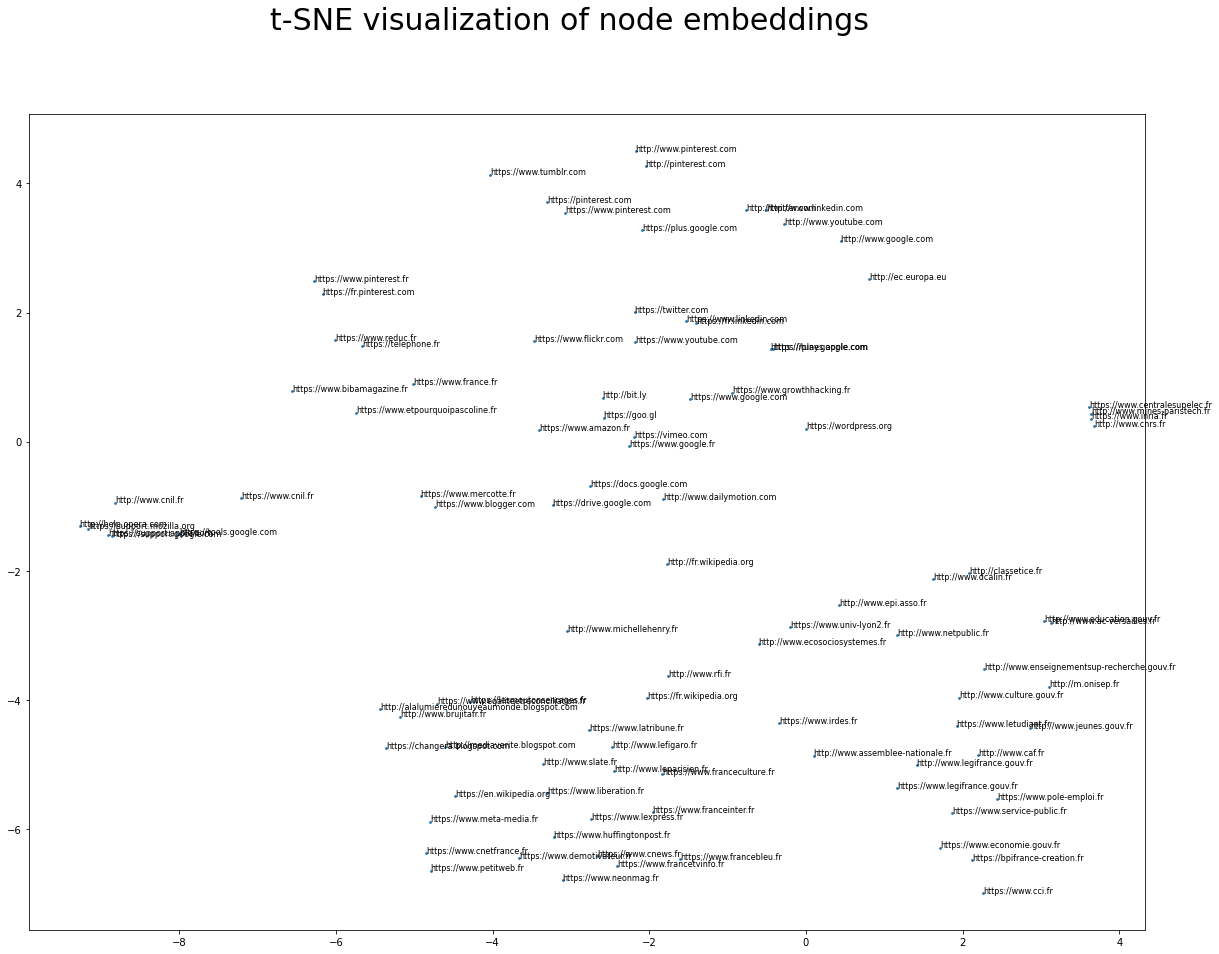

In [7]:
############## Task 4
# Visualizes the representations of the 100 nodes that appear most frequently in the generated walks
def visualize(model, n, dim):
  n_most_frequent_nodes=[]
  nodes = skipgram_model.wv.index_to_key
  for index, node in enumerate(model.wv.index_to_key):
    if index == n:
      break
    else:
      n_most_frequent_nodes.append(node)  ##list of top n most frequent nodes
  i=0
  DeepWalk_embeddings = np.empty(shape=(n, dim))
  for node in n_most_frequent_nodes:
    DeepWalk_embeddings[i, :] = model.wv[node]
    i=i+1

  my_pca = PCA(n_components=10)
  my_tsne = TSNE(n_components=2)

  vecs_pca = my_pca.fit_transform(DeepWalk_embeddings)
  vecs_tsne = my_tsne.fit_transform(vecs_pca)

  fig, ax = plt.subplots()
  ax.scatter(vecs_tsne[:,0], vecs_tsne[:,1],s=3)
  for x, y, node in zip(vecs_tsne[:,0] , vecs_tsne[:,1], nodes):     
      ax.annotate(node, xy=(x, y), size=8)
  fig.suptitle('t-SNE visualization of node embeddings',fontsize=30)
  fig.set_size_inches(20,15)
  plt.savefig('embeddings.pdf')  
  plt.show()

visualize(skipgram_model, 100, n_dim)

##Node Classification

In [8]:
# Loads the karate network
G_karate = nx.read_weighted_edgelist('/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab5_DeepWalk_GCN/code/data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

n = G_karate.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab5_DeepWalk_GCN/code/data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G_karate.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)

Number of nodes: 33226
Number of edges: 354529


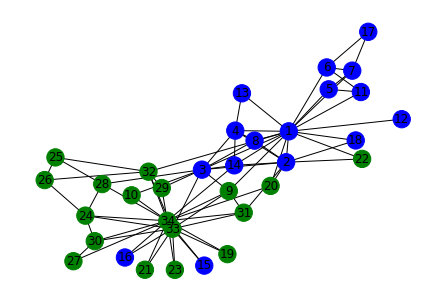

In [9]:
############## Task 5
color_map = []
for node in G_karate:
    if y[node-1] == 0:
        color_map.append('blue')
    else: 
        color_map.append('green')      
nx.draw(G_karate, node_color=color_map, with_labels=True)
plt.show()


In [10]:
############## Task 6
# Extracts a set of random walks from the karate network and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20
skipgram_model_karate = deepwalk(G_karate, n_walks, walk_length, n_dim) # your code here
print(len(skipgram_model_karate.wv.index_to_key))

embeddings = np.zeros((n, n_dim))
for i, node in enumerate(G_karate.nodes()):
    embeddings[i,:] = skipgram_model_karate.wv[str(node)]

idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

X_train = embeddings[idx_train,:]
X_test = embeddings[idx_test,:]

y_train = y[idx_train]
y_test = y[idx_test]


Generating walks
Training word2vec
34


In [11]:
############## Task 7
# Trains a logistic regression classifier and use it to make predictions
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print("accuracy train score =", clf.score(X_train, y_train))
print("accuracy test score =", clf.score(X_test, y_test))

accuracy train score = 0.9259259259259259
accuracy test score = 1.0


In [12]:
############## Task 8
# Generates spectral embeddings


def spectral_clustering(G, k):
    m = len(G.nodes)
    A = nx.to_numpy_array(G)
    degree_sequence = [G.degree(node) for node in G.nodes()]
    D = np.diag(degree_sequence)
    #Dinv = np.([1/d if d!=0 else 0. for d in degree_sequence])
    L = np.eye(m) - np.linalg.inv(D) @ A# Dinv@A
    _,eig_vec = eigs(L,k=k,which="SM")
    eig_vec = np.real(eig_vec) 
    y_pred = KMeans(n_clusters=k, random_state=0).fit_predict(normalize(eig_vec))
    clustering = dict((i,x) for i,x in enumerate(y_pred))
    return clustering



##################
# your code here #
##################

#Part 2 - Graph Neural Networks

##Implementation of Graph Neural Network

In [13]:
############## Task 9
def normalize_adjacency(A):
  A_t=A+sp.identity(A.shape[0])
  A_tilde=A_t.toarray()
  diag_vector=[]
  for i in range (0, A_tilde.shape[0]):
    sum=0
    for j in range(0, A_tilde.shape[0]):
      var=A_tilde[i][j]
      sum=sum+var.astype(float)
    diag_vector.append(sum)
  D_tilde=np.diag(diag_vector)
  A_hat=np.dot(np.dot(scipy.linalg.fractional_matrix_power(D_tilde, -0.5), A_tilde), scipy.linalg.fractional_matrix_power(D_tilde, -0.5))
  A_normalized=scipy.sparse.csr_matrix(A_hat)
  return A_normalized

In [14]:
def load_cora():
    idx_features_labels = np.genfromtxt("/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab5_DeepWalk_GCN/code/data/cora.content", dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    features = features.todense()
    features /= features.sum(1).reshape(-1, 1)
    
    class_labels = idx_features_labels[:, -1]
    le = LabelEncoder()
    class_labels = le.fit_transform(class_labels)

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab5_DeepWalk_GCN/code/data/cora.cites", dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(class_labels.size, class_labels.size), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    print('Dataset has {} nodes, {} edges, {} features.'.format(adj.shape[0], edges.shape[0], features.shape[1]))

    return features, adj, class_labels


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [29]:
class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        ############## Tasks 10 and 13
        print(x_in.size())
        print(torch.mm(adj,self.fc1(x_in)).size())
        x = self.relu(torch.mm(adj,self.fc1(x_in)))
        print(x.size())
        x = self.dropout(x)
        print(x.size())
        x = self.relu(torch.mm(adj,self.fc2(x)))
        print(x.size())
        x = self.fc3(x)
        print(x.size())
        return F.log_softmax(x, dim=1)


##Node Classification

###Task 12: initial features

In [30]:
# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden`_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab5_DeepWalk_GCN/code/data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print(G.number_of_nodes())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab5_DeepWalk_GCN/code/data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

############## Task 12
# Set the feature of all nodes to the same value
features = np.eye(n) # Generates node features

# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)



# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
test()

34
torch.Size([34, 34])
torch.Size([34, 8])
torch.Size([34, 8])
torch.Size([34, 8])
torch.Size([34, 16])
torch.Size([34, 2])
Epoch: 001 loss_train: 0.6866 acc_train: 0.5556 time: 0.0117s
torch.Size([34, 34])
torch.Size([34, 8])
torch.Size([34, 8])
torch.Size([34, 8])
torch.Size([34, 16])
torch.Size([34, 2])
Epoch: 002 loss_train: 0.6859 acc_train: 0.5556 time: 0.0066s
torch.Size([34, 34])
torch.Size([34, 8])
torch.Size([34, 8])
torch.Size([34, 8])
torch.Size([34, 16])
torch.Size([34, 2])
Epoch: 003 loss_train: 0.6828 acc_train: 0.5556 time: 0.0061s
torch.Size([34, 34])
torch.Size([34, 8])
torch.Size([34, 8])
torch.Size([34, 8])
torch.Size([34, 16])
torch.Size([34, 2])
Epoch: 004 loss_train: 0.6794 acc_train: 0.5556 time: 0.0062s
torch.Size([34, 34])
torch.Size([34, 8])
torch.Size([34, 8])
torch.Size([34, 8])
torch.Size([34, 16])
torch.Size([34, 2])
Epoch: 005 loss_train: 0.6710 acc_train: 0.5926 time: 0.0064s
torch.Size([34, 34])
torch.Size([34, 8])
torch.Size([34, 8])
torch.Size([34, 

###Task 12: Replace features with matrix of rank 1

In [26]:
# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab5_DeepWalk_GCN/code/data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print(G.number_of_nodes())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab5_DeepWalk_GCN/code/data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

############## Task 12
# Set the feature of all nodes to the same value
features = np.ones((n,n)) # Generates node features, matrix rank A

# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)



# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
#test()

34
Epoch: 001 loss_train: 0.6918 acc_train: 0.4444 time: 0.0021s
Epoch: 002 loss_train: 0.6874 acc_train: 0.5556 time: 0.0020s
Epoch: 003 loss_train: 0.6891 acc_train: 0.5556 time: 0.0016s
Epoch: 004 loss_train: 0.6909 acc_train: 0.5556 time: 0.0015s
Epoch: 005 loss_train: 0.6850 acc_train: 0.5556 time: 0.0019s
Epoch: 006 loss_train: 0.6889 acc_train: 0.5556 time: 0.0017s
Epoch: 007 loss_train: 0.6863 acc_train: 0.5556 time: 0.0016s
Epoch: 008 loss_train: 0.6897 acc_train: 0.5556 time: 0.0015s
Epoch: 009 loss_train: 0.6869 acc_train: 0.5926 time: 0.0015s
Epoch: 010 loss_train: 0.6862 acc_train: 0.6667 time: 0.0015s
Epoch: 011 loss_train: 0.6884 acc_train: 0.6296 time: 0.0015s
Epoch: 012 loss_train: 0.6871 acc_train: 0.6296 time: 0.0016s
Epoch: 013 loss_train: 0.6839 acc_train: 0.6296 time: 0.0015s
Epoch: 014 loss_train: 0.6835 acc_train: 0.6296 time: 0.0015s
Epoch: 015 loss_train: 0.6828 acc_train: 0.6296 time: 0.0015s
Epoch: 016 loss_train: 0.6827 acc_train: 0.5556 time: 0.0016s
Epoch

###Task 13

Dataset has 2708 nodes, 5429 edges, 1433 features.
Epoch: 001 loss_train: 1.9406 acc_train: 0.1706 loss_val: 1.9197 acc_val: 0.3210 time: 0.0975s
Epoch: 002 loss_train: 1.9271 acc_train: 0.3023 loss_val: 1.9075 acc_val: 0.3210 time: 0.0799s
Epoch: 003 loss_train: 1.9152 acc_train: 0.3023 loss_val: 1.8944 acc_val: 0.3210 time: 0.0801s
Epoch: 004 loss_train: 1.9026 acc_train: 0.3023 loss_val: 1.8806 acc_val: 0.3210 time: 0.0832s
Epoch: 005 loss_train: 1.8888 acc_train: 0.3023 loss_val: 1.8649 acc_val: 0.3210 time: 0.0835s
Epoch: 006 loss_train: 1.8741 acc_train: 0.3023 loss_val: 1.8462 acc_val: 0.3210 time: 0.0836s
Epoch: 007 loss_train: 1.8562 acc_train: 0.3023 loss_val: 1.8265 acc_val: 0.3210 time: 0.0869s
Epoch: 008 loss_train: 1.8396 acc_train: 0.3023 loss_val: 1.8078 acc_val: 0.3210 time: 0.0827s
Epoch: 009 loss_train: 1.8195 acc_train: 0.3023 loss_val: 1.7924 acc_val: 0.3210 time: 0.0846s
Epoch: 010 loss_train: 1.8070 acc_train: 0.3023 loss_val: 1.7824 acc_val: 0.3210 time: 0.1017s

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


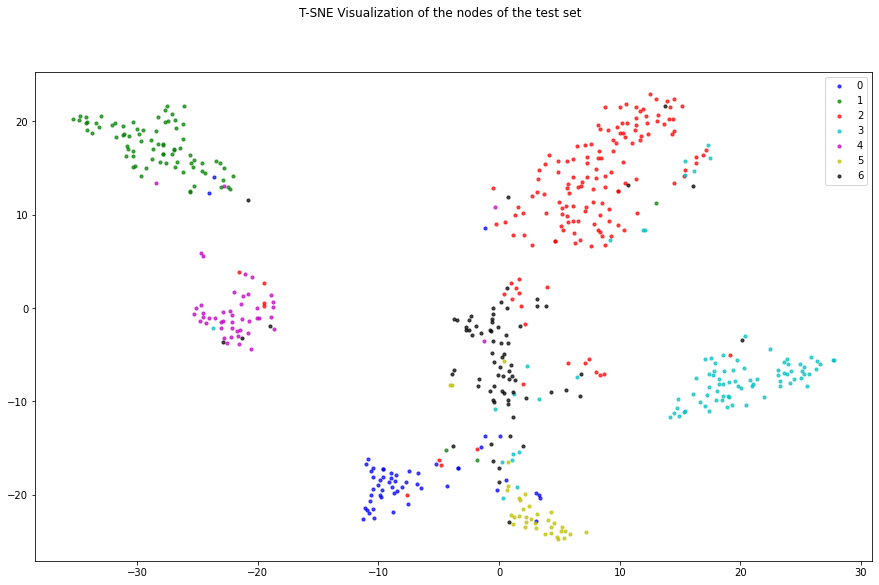

In [27]:
#Modify GNN so it can output the second message passing layer
class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, adj):
        ############## Tasks 10 and 13
        x = self.relu(torch.mm(adj,self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(torch.mm(adj,self.fc2(x)))
        y = x.clone()
        x = self.fc3(x)
        return F.log_softmax(x, dim=1), y

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 64
n_hidden_2 = 32
learning_rate = 0.01
dropout_rate = 0.5

# Read data
features, adj, class_labels = load_cora()
n = adj.shape[0] # Number of nodes
n_class = np.unique(class_labels).size # Number of classes

adj = normalize_adjacency(adj) # Normalize adjacency matrix

# Yields indices to split data into training, validation and test sets
idx = np.random.permutation(n)
idx_train = idx[:int(0.6*n)]
idx_val = idx[int(0.6*n):int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transform the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(class_labels).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output,_ = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    
    model.eval()
    output,_ = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], y[idx_val])
    acc_val = accuracy_score(torch.argmax(output[idx_val], dim=1).detach().cpu().numpy(), y[idx_val].cpu().numpy())
    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, embeddings = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))

    return embeddings[idx_test]


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
embeddings_test = test()

############## Task 13
# Transforms torch tensor to numpy matrix

embeddings_test = embeddings_test.detach().cpu().numpy()

# Projects the emerging representations to two dimensions using t-SNE

embeddings_test_2d = TSNE().fit_transform(embeddings_test)

labels = class_labels[idx_test.cpu()]
unique_labels = np.unique(labels)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots()
for i in range(unique_labels.size):
    idxs = [j for j in range(labels.size) if labels[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0], 
               embeddings_test_2d[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization of the nodes of the test set',fontsize=12)
fig.set_size_inches(15,9)
plt.show()

#Question 4 

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (2, 0)	1
  (2, 1)	1
  (2, 3)	1
  (3, 0)	1
  (3, 1)	1
  (3, 2)	1
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Z0_before_ReLU_K4 : 
[[-0.8  0.5]
 [-0.8  0.5]
 [-0.8  0.5]
 [-0.8  0.5]]
z0_K4 : 
[[0.  0.5]
 [0.  0.5]
 [0.  0.5]
 [0.  0.5]]
Z1_before_ReLU : 
[[-0.2   0.3   0.25]
 [-0.2   0.3   0.25]
 [-0.2   0.3   0.25]
 [-0.2   0.3   0.25]]
z1_K4 : 
[[0.   0.3  0.25]
 [0.   0.3  0.25]
 [0.   0.3  0.25]
 [0.   0.3  0.25]]


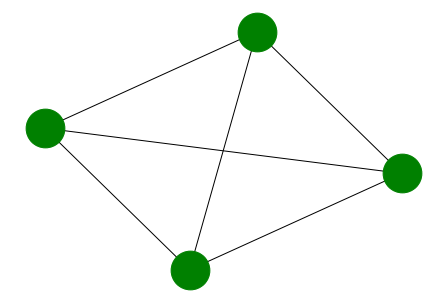

In [124]:
import networkx
#complete graph K4
K4 = networkx.complete_graph(4)
 
networkx.draw(K4, node_color = 'green',node_size = 1500)


X=np.array([[1],
           [1], 
           [1], 
           [1]])

W0=np.array([[-0.8, 0.5]])

W1=np.array([[0.1, 0.3, -0.05], 
              [-0.4, 0.6, 0.5]])

adj_K4 = nx.adjacency_matrix(K4)
print(adj_K4)
adj_K4 = normalize_adjacency(adj_K4).todense()

print(adj_K4)

Z0_before_ReLU_K4=np.dot(adj_K4, np.dot(X, W0))

print("Z0_before_ReLU_K4 : ")
print(Z0_before_ReLU_K4)

z0_K4=np.array([[0.0, 0.5], 
                [0.0, 0.5], 
                [0.0, 0.5], 
                [0.0, 0.5]])
print("z0_K4 : ")
print(z0_K4)
Z1_before_ReLU=np.dot(adj_K4, np.dot(z0_K4, W1))
print("Z1_before_ReLU : ")
print(Z1_before_ReLU)

z1_K4=np.array([[0.0, 0.3, 0.25],
               [0.0, 0.3, 0.25], 
               [0.0, 0.3, 0.25], 
               [0.0, 0.3, 0.25]])

print("z1_K4 : ")
print(z1_K4)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (2, 0)	1
  (3, 0)	1
[[0.25       0.35355339 0.35355339 0.35355339]
 [0.35355339 0.5        0.         0.        ]
 [0.35355339 0.         0.5        0.        ]
 [0.35355339 0.         0.         0.5       ]]
Z0_before_ReLU_S4 : 
[[-1.04852814  0.65533009]
 [-0.68284271  0.4267767 ]
 [-0.68284271  0.4267767 ]
 [-0.68284271  0.4267767 ]]
z0_S4 : 
[[0.         0.65533009]
 [0.         0.4267767 ]
 [0.         0.4267767 ]
 [0.         0.4267767 ]]
Z1_before_ReLU : 
[[-0.24659903  0.36989854  0.30824879]
 [-0.17803301  0.26704952  0.22254126]
 [-0.17803301  0.26704952  0.22254126]
 [-0.17803301  0.26704952  0.22254126]]
z1_S4 : 
[[0.         0.36989854 0.30824879]
 [0.         0.26704952 0.22254126]
 [0.         0.26704952 0.22254126]
 [0.         0.26704952 0.22254126]]


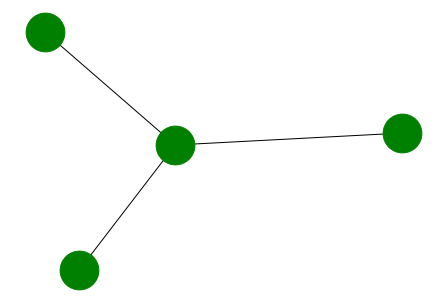

In [149]:
import networkx


#complete graph S4 
S4 = networkx.star_graph(3)
 
networkx.draw(S4, node_color = 'green',node_size = 1500)
X=np.array([[1],
           [1], 
           [1], 
           [1]])
W0=np.array([[-0.8, 0.5]])

W1=np.array([[0.1, 0.3, -0.05], 
              [-0.4, 0.6, 0.5]])

adj_S4 = nx.adjacency_matrix(S4)
print(adj_S4)

adj_S4 = normalize_adjacency(adj_S4).todense()
print(adj_S4)

Z0_before_ReLU_S4=np.dot(adj_S4, np.dot(X, W0))

print("Z0_before_ReLU_S4 : ")
print(Z0_before_ReLU_S4)

z0_S4=np.array([[0.0, 0.65533009], 
                [0.0, 0.4267767], 
                [0.0, 0.4267767],
                [0.0, 0.4267767],
])


print("z0_S4 : ")
print(z0_S4)
Z1_before_ReLU=np.dot(adj_S4, np.dot(z0_S4, W1))
print("Z1_before_ReLU : ")
print(Z1_before_ReLU)

z1_S4=np.array([[0.0, 0.36989854,  0.30824879],
                [0.0, 0.26704952,  0.22254126], 
                [0.0, 0.26704952,  0.22254126], 
                [0.0, 0.26704952,  0.22254126]])
print("z1_S4 : ")
print(z1_S4)

In [146]:
print("z1_K4 : ")
print(z1_K4)
print("z1_S4 : ")
print(z1_S4)

z1_K4 : 
[[0.   0.3  0.25]
 [0.   0.3  0.25]
 [0.   0.3  0.25]
 [0.   0.3  0.25]]
z1_S4 : 
[[0.         0.36989854 0.30824879]
 [0.         0.26704952 0.22254126]
 [0.         0.26704952 0.22254126]
 [0.         0.26704952 0.22254126]]
